---



# <font color='#ECA702'>**Análisis Multimodal de Síntomas en la Enfermedad de Parkinson**</font>

In [1]:
#@title **Importar librerías**

# Manipulación de datos
import os
import cv2
import numpy as np
import librosa
import pandas as pd
from zipfile import ZipFile

# Pytorch essentials
import torch
import torch.nn as nn
import torch.nn.functional as F

# Pytorch essentials for datasets.
from torch.utils.data import Dataset, DataLoader, ConcatDataset

# Utils
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
import pytz

# sklearn
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [3]:
#@title **Cargamos los datos desde Drive**

from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/data_parkinson')
print(os.getcwd())

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1XRruCPRodR4OhRCRZYKsyODqa_GuBkfC/data_parkinson


In [4]:
#@title **Extraer el zip**

os.mkdir('../../../../data')
os.popen('cp data.csv ../../../../data/data.csv')
target_path = os.path.join('../../../../data') # Aquí es donde van a quedar los datos
# deben quedar fuera de drive para poder acceder a ellos 'localmente'

# Unzip the downloaded files
zip_file_path = os.path.join('AudioVisualData_v7.zip')
with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(target_path)

# # Me muevo hasta donde quedaron los datos
%cd ../../../../data
# Verifico
%ls

/content/data
AudioVisualData_v7/  data.csv


## <font color='#4C5FDA'>**Procesamiento del dataset**</font>

### <font color='#52F17F'>**Creación del Dataset Pandas auxiliar**</font>

In [2]:
data = pd.read_csv("data.csv", index_col='patient')

def string2array(string: str):
  """ Convierte un string con datos a numpy array """
  string = string.strip('[]')
  return np.fromstring(string, sep=',')

data['flatten_log_mel_spectogram'] = data['flatten_log_mel_spectogram'].apply(string2array)
data.head()

,audio_path,frames_path,label,flatten_log_mel_spectogram
patient,,,,
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.66636657714844, -19.715749740600586, -24...."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-61.8838005065918, -28.279430389404297, -28.8..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-59.091400146484375, -25.001014709472656, -28..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.556915283203125, -20.145050048828125, -20..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-69.82708740234375, -20.313282012939453, -26...."


### <font color='#52F17F'>**Creación del Dataset PyTorch**</font>

In [3]:
"""
Constante sacada de la media de cantidad de frames de todos los vídeos multiplicada por 0.1
para tener el 10%
"""

FRAMES_PROMEDIO = 14

In [4]:
class PatientDataset(Dataset):
  def __init__(self, dataframe, n_frames = FRAMES_PROMEDIO):
    self.dataframe = dataframe
    # self.transform = transform
    self.n_frames = n_frames
    # self.audios = sorted(os.listdir(audio_dir)) # Listamos todas las imagenes en la carpeta

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, index):

    """ Carga de la imagen """

    # Entramos a la carpeta y conseguimos el audio de la lista
    # audio_path = os.path.join(self.audio_dir, self.audios[index])
    # audio_path = os.path.join(self.dataframe['audio_path'][index])

    # Leemos el audio
    audio = self.dataframe['flatten_log_mel_spectogram'][index].astype(np.float32)
    audio = audio.reshape((90, 10))
    audio = torch.from_numpy(audio).unsqueeze(0)

    """ Carga de los frames """

    # Entramos a la carpeta y conseguimos los frames de la lista.
      # La razon por la que uso la misma lista de audios es porque el audio y el vídeo
      # tienen el mismo nombre, solo cambia la ruta de la carpeta y la extensión.
    """ audios: AudioVisualData_v7/Control/C0/Phonemes/audio/C0-1-Pakata.mp3 """
    """ vídeo: AudioVisualData_v7/Control/C0/Phonemes/frames/C0-1-Pakata.mov """
    video_path = os.path.join(self.dataframe['frames_path'][index])
    # video_path = os.path.join(self.video_dir, self.audios[index].replace(".mp3", ".mov"))

    frames_path = sorted(os.listdir(video_path))[:self.n_frames]
    frames = []
    for frame in frames_path:
      frame_path = os.path.join(self.dataframe['frames_path'][index], frame)
      # print(frame_path)
      frame = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)
      frame = cv2.resize(frame, (112, 112)) # Resize a 112x112
      frame = frame / 255. # Normalizamos entre 0 y 1
      frames.append(frame)

    frames = np.expand_dims(np.stack(frames), axis=1).astype('float32')
    frames = frames.transpose(1, 0, 2, 3)
    frames = torch.from_numpy(frames)

    """ Consiguiendo el label """

    # Para conseguir la etiqueta simplemente me tengo que fijar en la ruta. Si es 'Parkinson' 1
    # sino 0.

    label = 1 if 'Parkinson' in self.dataframe['audio_path'][index] else 0

    return audio, frames, label

In [5]:
complete_dataset = PatientDataset(data)
print(complete_dataset.__len__())
print(complete_dataset[0][0].shape, complete_dataset[0][1].shape , complete_dataset[0][2])

1091
torch.Size([1, 90, 10]) torch.Size([1, 14, 112, 112]) 0


### <font color='#52F17F'>**Visualización de los datos**</font>

In [6]:
def plot_frame_strip(frames, rows=2, cols=7):
    """
    Hace un plot de la tira de frames en una matriz de imágenes.

    Args:
        frames (np.ndarray): Tensor de frames con forma (num_frames, height, width, channels).
        rows (int): Número de filas en la tira de frames.
        cols (int): Número de columnas en la tira de frames.
    """
    fig, axes = plt.subplots(rows, cols, figsize=(20, 6))

    for i in range(rows):
        for j in range(cols):
            idx = i * cols + j
            if idx < len(frames):
                axes[i, j].imshow(frames[idx], cmap='gray')
                axes[i, j].axis('off')
                axes[i, j].set_title(f"Frame: {idx}")
    plt.show()

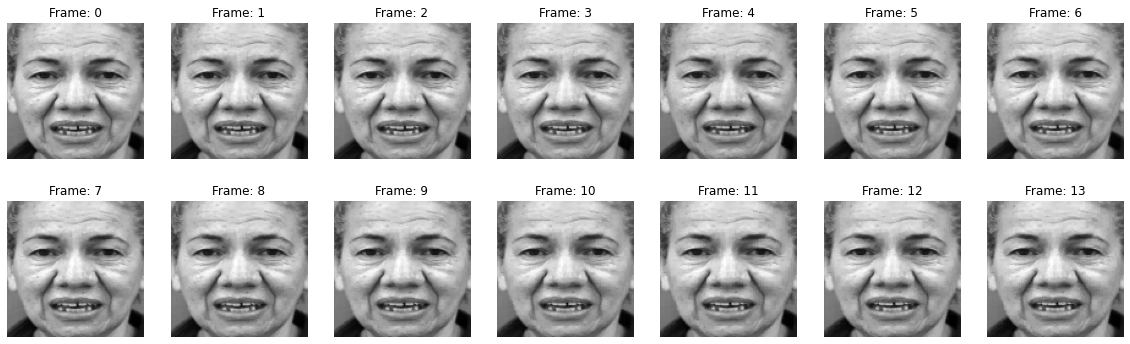

In [7]:
plot_frame_strip(complete_dataset[0][1].squeeze(0).numpy())

In [8]:
complete_dataset[0][0].squeeze(0).numpy().reshape((90, 10)).shape

(90, 10)

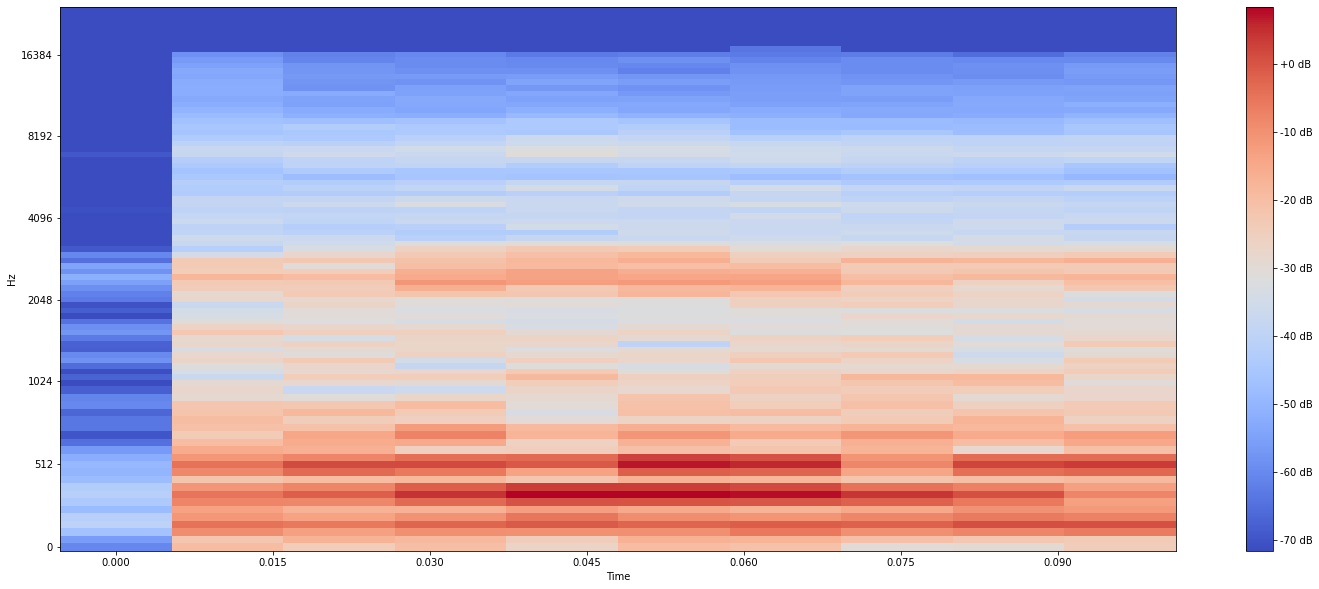

In [9]:
plt.figure(figsize=(25,10))
librosa.display.specshow(complete_dataset[0][0].squeeze(0).numpy(), y_axis='mel', x_axis='time', sr=48000)
plt.colorbar(format="%+2.f dB")
plt.show()

### <font color='#52F17F'>**Partición de los datos**</font>

In [10]:
# Extraer los datos para GroupKFold https://discuss.pytorch.org/t/custom-datatype-for-many-images-to-one-label/87629
X = [i for i in range(len(data))]
y = data['label'].values
groups = data.index.values

In [11]:
groupk_folds = 7
gkf = GroupKFold(n_splits=groupk_folds)
# Realizar la validación cruzada por grupos
for i, (train_index, test_index) in enumerate(gkf.split(X, y, groups), 1):
    train_groups = groups[train_index]
    test_groups = groups[test_index]

    print(f"División {i}:")
    print("  Pacientes en entrenamiento:", np.unique(train_groups))
    print("  Pacientes en prueba:", np.unique(test_groups))
    print("  Número de pacientes en entrenamiento:", len(np.unique(train_groups)))
    print("  Número de pacientes en prueba:", len(np.unique(test_groups)))
    print()

División 1:
  Pacientes en entrenamiento: ['C0' 'C1' 'C2' 'C3' 'C4' 'C6' 'P0' 'P1' 'P4' 'P5' 'P6' 'P7']
  Pacientes en prueba: ['C5' 'P8']
  Número de pacientes en entrenamiento: 12
  Número de pacientes en prueba: 2

División 2:
  Pacientes en entrenamiento: ['C0' 'C1' 'C2' 'C3' 'C5' 'C6' 'P0' 'P1' 'P4' 'P5' 'P6' 'P8']
  Pacientes en prueba: ['C4' 'P7']
  Número de pacientes en entrenamiento: 12
  Número de pacientes en prueba: 2

División 3:
  Pacientes en entrenamiento: ['C0' 'C1' 'C2' 'C4' 'C5' 'C6' 'P0' 'P1' 'P4' 'P5' 'P7' 'P8']
  Pacientes en prueba: ['C3' 'P6']
  Número de pacientes en entrenamiento: 12
  Número de pacientes en prueba: 2

División 4:
  Pacientes en entrenamiento: ['C0' 'C1' 'C3' 'C4' 'C5' 'C6' 'P0' 'P1' 'P4' 'P6' 'P7' 'P8']
  Pacientes en prueba: ['C2' 'P5']
  Número de pacientes en entrenamiento: 12
  Número de pacientes en prueba: 2

División 5:
  Pacientes en entrenamiento: ['C0' 'C2' 'C3' 'C4' 'C5' 'C6' 'P0' 'P1' 'P5' 'P6' 'P7' 'P8']
  Pacientes en prueba: [

## <font color='#ECA702'>**Modelo CNN**</font>

### <font color='#52F17F'>**Creando el modelo**</font>

In [12]:
class MultimodalModel(nn.Module):
  def __init__(self, n_channels):
    super().__init__()
    # self.audio_model = AudioModule(n_channels, n_classes)
    # self.video_model = VideoModule(n_channels, n_classes)
    self.fc1 = nn.Linear((1 * 14 * 112 * 112) + (1 * 90 * 10), 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 32)
    self.fc4 = nn.Linear(32, 1)  # Suponiendo que es una tarea de clasificación binaria

  def forward(self, audio, video):
    # https://stackoverflow.com/questions/42479902/what-does-view-do-in-pytorch
    audio = audio.view(audio.size(0), -1) # Aplane los audios conservando el batch
    # devuelve: # batch_size x (90*10)

    video = video.view(video.size(0), -1) # Aplane los videos conservando el batch
    # devuelve: # batch_size x (14*112*112)

    combined = torch.cat((video, audio), dim=1) # https://pytorch.org/docs/stable/generated/torch.cat.html
    x = F.relu(self.fc1(combined))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x

In [13]:
# Test al modelo, para ver si nos entrega la salida esperada

n_channels = 1
n_classes = 2
input_audio = complete_dataset[0][0].unsqueeze(0)
input_video = complete_dataset[0][1].unsqueeze(0)
print(f"Entrada audio: {input_audio.size(), input_audio.dtype}")
print(f"Entrada video: {input_video.size(), input_video.dtype}")

model = MultimodalModel(n_channels=n_channels)
ouput = model(input_audio, input_video)
print(f"Salida: {ouput.size()}")

Entrada audio: (torch.Size([1, 1, 90, 10]), torch.float32)
Entrada video: (torch.Size([1, 1, 14, 112, 112]), torch.float32)
Salida: torch.Size([1, 1])


In [76]:
# Test al modelo, para ver si nos entrega la salida esperada

n_channels = 1
n_classes = 2
input_video = torch.rand([2, 1, 14, 112, 112])
input_audio = torch.rand([2, 1, 90, 10])

print(f"Entrada audio: {input_audio.size(), input_audio.dtype}")
print(f"Entrada video: {input_video.size(), input_video.dtype}")

model = MultimodalModel(n_channels=n_channels)
ouput = model(input_audio, input_video)
print(f"Salida: {ouput.size()}")

Entrada audio: (torch.Size([2, 1, 90, 10]), torch.float32)
Entrada video: (torch.Size([2, 1, 14, 112, 112]), torch.float32)
Salida: torch.Size([2, 1])


### <font color='#52F17F'>**Entrenamiento del modelo**</font>

In [111]:
# Hiperparametros
LEARNING_RATE = 0.01
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 8

In [112]:
# For fold results

# Acá vamos a guardar las métricas del modelo
results = {
    "accuracy": [],
    "recall": [],
    "precision": [],
    "f1_score": []
}

# Storage for plotting
losses_per_epoch = []

# Esto es para guardar los modelos de cada experimento en carpetas separadas
timezone = pytz.timezone('America/Bogota')
timestamp = datetime.now(timezone).strftime('%Y%m%d_%H%M')
exp_path = f'../models/exp_{timestamp}'
figures_exp_path = f'../reports/figures/exp_{timestamp}'
os.mkdir(exp_path)
os.mkdir(figures_exp_path)

In [83]:
#@title **training loop**

def train_one_epoch(trainloader, model, optimizer, criterion, losses):
  n_prints = int(len(trainloader)/3)
  running_loss = 0.0
  for i, data in enumerate(tqdm(trainloader, 0)):
    # get the inputs; data is a list of [inputs, labels]
    audios, videos, labels = data

    # Movemos los datos al device
    audios = audios.to(DEVICE)
    videos = videos.to(DEVICE)
    labels = labels.unsqueeze(1).float() #convert target to same nn output shape
    labels = labels.to(DEVICE)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(audios, videos)
    # print(ouputs.dtype)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i % n_prints == n_prints-1:    # print every n_print mini-batches
      print(f'batch {i + 1:5d} loss: {running_loss / (i + 1):.3f}')
      # Store loss per epoch
      losses.append(np.round(running_loss / (i+1), 3))
      # running_loss = 0.0
  # return losses

In [85]:
#@title **eval loop**

def eval_model(testloader, model, y_pred, y_true):
  with torch.no_grad():
    # Iterate over the test data and generate predictions
    for i, data in enumerate(testloader, 0):
      # Get inputs
      audios, videos, labels = data

      # Movemos los datos al device
      audios = audios.to(DEVICE)
      videos = videos.to(DEVICE)
      labels = labels.unsqueeze(1).float() #convert target to same nn output shape

      #model to eval mode
      model.eval()

      # Generate outputs
      outputs = model(audios, videos)

      # total += labels.size(0)
      y_pred.extend(torch.sigmoid(outputs).round().cpu().numpy())
      y_true.extend(labels.numpy())

In [113]:
# Loop encontrado y modificado de: https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-pytorch.md
for fold, (train_ids, test_ids) in enumerate(gkf.split(X, y, groups)):

  # Print
  print(f'FOLD {fold+1}')
  print('--------------------------------')

  # Sample elements randomly from a given list of ids, no replacement.
  train_subsampler = torch.utils.data.Subset(complete_dataset, train_ids)
  test_subsampler = torch.utils.data.Subset(complete_dataset, test_ids)

  # Define data loaders for training and testing data in this fold
  trainloader = DataLoader(train_subsampler, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
  testloader = DataLoader(test_subsampler, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


  """ Parametros del modelo """

  # Creacion del modelo y lo movemos a la GPU o CPU
  model = MultimodalModel(n_channels=1)
  model.to(DEVICE)

  # Funcion de perdida (loss)
  criterion = nn.BCEWithLogitsLoss() # https://shivambaldha.medium.com/binary-classification-with-pytorch-85089b284940

  # Algoritmos de optimización del gradiente
  optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

  epoch_number = 0
  EPOCHS = 10

  # Storage for current fold
  losses = []

  for epoch in range(EPOCHS):  # loop over the dataset multiple times
      print(f"EPOCH {epoch_number + 1}")

      train_one_epoch(trainloader, model, optimizer, criterion, losses)

      epoch_number += 1 # Pasamos a la siguiente época

  # Store losses for current fold
  losses_per_epoch.append(losses)

  # Process is complete.
  print('Training process has finished. Saving trained model.')

  # Print about testing
  print('Starting testing')

  # Saving the model
  # Crear la carpeta models por si no existe
  if os.path.exists('../models') == False:
    os.mkdir("../models")
  save_path = f'{exp_path}/model-fold-{fold+1}.pth'
  torch.save(model.state_dict(), save_path)

  # Evaluation for this fold
  y_true = []
  y_pred = []

  eval_model(testloader, model, y_pred, y_true)

  # Calculate metrics
  recall = recall_score(y_true, y_pred, average='binary')
  precision = precision_score(y_true, y_pred, average='binary') 
  f1 = f1_score(y_true, y_pred, average='binary')
  accuracy = accuracy_score(y_true, y_pred)

  # Print metrics
  print('--------------------------------')
  print(f'Accuracy for fold {fold+1}: {accuracy * 100:.2f}%')
  print(f'Recall for fold {fold+1}: {recall * 100:.2f}%')
  print(f'Precision for fold {fold+1}: {precision * 100:.2f}%')
  print(f'F1 Score for fold {fold+1}: {f1 * 100:.2f}%')
  print('--------------------------------')

  results["accuracy"].append(accuracy * 100)
  results["recall"].append(recall * 100)
  results["precision"].append(precision * 100)
  results["f1_score"].append(f1 * 100)

# Print fold results
print(f'GROUP K-FOLD CROSS VALIDATION RESULTS FOR {groupk_folds} FOLDS')
print('--------------------------------')
for metric, values in results.items():
    print(f'{metric.capitalize()}:')
    # for fold_idx, value in enumerate(values, 1):
    #     print(f'  Fold {fold_idx}: {value:.2f}')
    print(f'  Average: {np.mean(values):.2f}% (+/- {np.std(values):.2f}%)')

FOLD 1
--------------------------------
EPOCH 1


 35%|███▌      | 41/117 [00:03<00:06, 11.71it/s]

batch    39 loss: 10.942


 68%|██████▊   | 79/117 [00:07<00:03, 10.84it/s]

batch    78 loss: 5.696


100%|██████████| 117/117 [00:10<00:00, 10.88it/s]


batch   117 loss: 3.989
EPOCH 2


 35%|███▌      | 41/117 [00:03<00:06, 11.16it/s]

batch    39 loss: 0.271


 68%|██████▊   | 79/117 [00:07<00:03, 10.67it/s]

batch    78 loss: 0.443


100%|██████████| 117/117 [00:10<00:00, 10.91it/s]


batch   117 loss: 0.527
EPOCH 3


 35%|███▌      | 41/117 [00:03<00:06, 11.06it/s]

batch    39 loss: 0.693


 68%|██████▊   | 79/117 [00:07<00:03, 11.11it/s]

batch    78 loss: 0.694


100%|██████████| 117/117 [00:10<00:00, 10.92it/s]


batch   117 loss: 0.694
EPOCH 4


 35%|███▌      | 41/117 [00:03<00:06, 11.02it/s]

batch    39 loss: 0.693


 69%|██████▉   | 81/117 [00:07<00:03, 11.23it/s]

batch    78 loss: 0.693


100%|██████████| 117/117 [00:10<00:00, 10.91it/s]


batch   117 loss: 0.694
EPOCH 5


 35%|███▌      | 41/117 [00:03<00:06, 10.95it/s]

batch    39 loss: 0.694


 68%|██████▊   | 79/117 [00:07<00:03, 10.64it/s]

batch    78 loss: 0.693


100%|██████████| 117/117 [00:10<00:00, 10.66it/s]


batch   117 loss: 0.694
EPOCH 6


 33%|███▎      | 39/117 [00:03<00:07, 10.87it/s]

batch    39 loss: 0.694


 68%|██████▊   | 79/117 [00:07<00:03, 10.57it/s]

batch    78 loss: 0.694


100%|██████████| 117/117 [00:11<00:00, 10.61it/s]


batch   117 loss: 0.694
EPOCH 7


 35%|███▌      | 41/117 [00:03<00:06, 11.55it/s]

batch    39 loss: 0.693


 69%|██████▉   | 81/117 [00:07<00:03, 10.95it/s]

batch    78 loss: 0.694


100%|██████████| 117/117 [00:10<00:00, 10.90it/s]


batch   117 loss: 0.694
EPOCH 8


 35%|███▌      | 41/117 [00:03<00:07, 10.80it/s]

batch    39 loss: 0.694


 68%|██████▊   | 79/117 [00:07<00:03, 11.77it/s]

batch    78 loss: 0.694


100%|██████████| 117/117 [00:10<00:00, 10.77it/s]


batch   117 loss: 0.694
EPOCH 9


 35%|███▌      | 41/117 [00:03<00:07, 10.75it/s]

batch    39 loss: 0.694


 68%|██████▊   | 79/117 [00:07<00:03, 11.26it/s]

batch    78 loss: 0.694


100%|██████████| 117/117 [00:10<00:00, 10.83it/s]


batch   117 loss: 0.694
EPOCH 10


 35%|███▌      | 41/117 [00:03<00:06, 11.48it/s]

batch    39 loss: 0.693


 68%|██████▊   | 79/117 [00:07<00:03, 11.89it/s]

batch    78 loss: 0.694


100%|██████████| 117/117 [00:10<00:00, 10.97it/s]

batch   117 loss: 0.694
Training process has finished. Saving trained model.
Starting testing



/home/guillermo/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


--------------------------------
Accuracy for fold 1: 50.00%
Recall for fold 1: 0.00%
Precision for fold 1: 0.00%
F1 Score for fold 1: 0.00%
--------------------------------
FOLD 2
--------------------------------
EPOCH 1


 33%|███▎      | 39/117 [00:03<00:06, 11.23it/s]

batch    39 loss: 7.339


 68%|██████▊   | 79/117 [00:07<00:03, 11.25it/s]

batch    78 loss: 4.233


100%|██████████| 117/117 [00:10<00:00, 10.76it/s]


batch   117 loss: 3.054
EPOCH 2


 35%|███▌      | 41/117 [00:03<00:06, 10.92it/s]

batch    39 loss: 0.694


 68%|██████▊   | 79/117 [00:07<00:03, 10.97it/s]

batch    78 loss: 0.694


100%|██████████| 117/117 [00:11<00:00, 10.54it/s]


batch   117 loss: 0.694
EPOCH 3


 35%|███▌      | 41/117 [00:04<00:06, 11.08it/s]

batch    39 loss: 0.694


 68%|██████▊   | 79/117 [00:07<00:03, 10.63it/s]

batch    78 loss: 0.694


100%|██████████| 117/117 [00:11<00:00, 10.51it/s]


batch   117 loss: 0.694
EPOCH 4


 35%|███▌      | 41/117 [00:03<00:07, 10.77it/s]

batch    39 loss: 0.694


 68%|██████▊   | 79/117 [00:07<00:03, 10.72it/s]

batch    78 loss: 0.694


100%|██████████| 117/117 [00:11<00:00, 10.52it/s]


batch   117 loss: 0.694
EPOCH 5


 35%|███▌      | 41/117 [00:03<00:06, 11.47it/s]

batch    39 loss: 0.694


 68%|██████▊   | 79/117 [00:07<00:03,  9.83it/s]

batch    78 loss: 0.694


100%|██████████| 117/117 [00:11<00:00, 10.45it/s]


batch   117 loss: 0.694
EPOCH 6


 35%|███▌      | 41/117 [00:04<00:07, 10.55it/s]

batch    39 loss: 0.693


 68%|██████▊   | 79/117 [00:07<00:03, 10.06it/s]

batch    78 loss: 0.694


100%|██████████| 117/117 [00:11<00:00, 10.32it/s]


batch   117 loss: 0.694
EPOCH 7


 35%|███▌      | 41/117 [00:03<00:07, 10.68it/s]

batch    39 loss: 0.694


 68%|██████▊   | 79/117 [00:07<00:03, 10.45it/s]

batch    78 loss: 0.694


100%|██████████| 117/117 [00:11<00:00, 10.35it/s]


batch   117 loss: 0.694
EPOCH 8


 35%|███▌      | 41/117 [00:03<00:06, 10.86it/s]

batch    39 loss: 0.693


 68%|██████▊   | 79/117 [00:07<00:03, 10.74it/s]

batch    78 loss: 0.693


100%|██████████| 117/117 [00:11<00:00, 10.48it/s]


batch   117 loss: 0.693
EPOCH 9


 35%|███▌      | 41/117 [00:04<00:07, 10.58it/s]

batch    39 loss: 0.693


 68%|██████▊   | 79/117 [00:07<00:03, 10.69it/s]

batch    78 loss: 0.694


100%|██████████| 117/117 [00:11<00:00, 10.41it/s]


batch   117 loss: 0.694
EPOCH 10


 35%|███▌      | 41/117 [00:04<00:07, 10.42it/s]

batch    39 loss: 0.694


 68%|██████▊   | 79/117 [00:07<00:03, 10.90it/s]

batch    78 loss: 0.694


100%|██████████| 117/117 [00:11<00:00, 10.36it/s]

batch   117 loss: 0.694
Training process has finished. Saving trained model.
Starting testing


--------------------------------
Accuracy for fold 2: 50.00%
Recall for fold 2: 100.00%
Precision for fold 2: 50.00%
F1 Score for fold 2: 66.67%
--------------------------------
FOLD 3
--------------------------------
EPOCH 1


 35%|███▌      | 41/117 [00:03<00:06, 11.49it/s]

batch    39 loss: 6.756


 68%|██████▊   | 79/117 [00:07<00:03, 10.79it/s]

batch    78 loss: 3.717


100%|██████████| 117/117 [00:10<00:00, 10.96it/s]


batch   117 loss: 2.682
EPOCH 2


 35%|███▌      | 41/117 [00:03<00:06, 11.22it/s]

batch    39 loss: 0.676


 68%|██████▊   | 79/117 [00:07<00:03, 11.40it/s]

batch    78 loss: 0.686


100%|██████████| 117/117 [00:10<00:00, 11.30it/s]


batch   117 loss: 0.690
EPOCH 3


 35%|███▌      | 41/117 [00:03<00:06, 11.71it/s]

batch    39 loss: 0.693


 69%|██████▉   | 81/117 [00:06<00:03, 11.82it/s]

batch    78 loss: 0.694


100%|██████████| 117/117 [00:10<00:00, 11.49it/s]


batch   117 loss: 0.694
EPOCH 4


 35%|███▌      | 41/117 [00:03<00:06, 11.56it/s]

batch    39 loss: 0.693


 68%|██████▊   | 79/117 [00:06<00:03, 11.78it/s]

batch    78 loss: 0.693


100%|██████████| 117/117 [00:10<00:00, 11.48it/s]


batch   117 loss: 0.694
EPOCH 5


 35%|███▌      | 41/117 [00:03<00:06, 12.21it/s]

batch    39 loss: 0.693


 68%|██████▊   | 79/117 [00:06<00:03, 11.16it/s]

batch    78 loss: 0.694


100%|██████████| 117/117 [00:10<00:00, 11.43it/s]


batch   117 loss: 0.694
EPOCH 6


 35%|███▌      | 41/117 [00:03<00:06, 11.54it/s]

batch    39 loss: 0.693


 68%|██████▊   | 79/117 [00:06<00:03, 12.07it/s]

batch    78 loss: 0.694


100%|██████████| 117/117 [00:10<00:00, 11.45it/s]


batch   117 loss: 0.694
EPOCH 7


 35%|███▌      | 41/117 [00:03<00:06, 10.95it/s]

batch    39 loss: 0.693


 68%|██████▊   | 79/117 [00:07<00:03, 10.89it/s]

batch    78 loss: 0.694


100%|██████████| 117/117 [00:10<00:00, 11.40it/s]


batch   117 loss: 0.694
EPOCH 8


 35%|███▌      | 41/117 [00:03<00:06, 11.41it/s]

batch    39 loss: 0.694


 69%|██████▉   | 81/117 [00:07<00:03, 11.16it/s]

batch    78 loss: 0.693


100%|██████████| 117/117 [00:10<00:00, 11.17it/s]


batch   117 loss: 0.694
EPOCH 9


 35%|███▌      | 41/117 [00:03<00:06, 11.22it/s]

batch    39 loss: 0.693


 68%|██████▊   | 79/117 [00:06<00:03, 11.47it/s]

batch    78 loss: 0.693


100%|██████████| 117/117 [00:10<00:00, 11.43it/s]


batch   117 loss: 0.694
EPOCH 10


 35%|███▌      | 41/117 [00:03<00:06, 11.20it/s]

batch    39 loss: 0.694


 68%|██████▊   | 79/117 [00:07<00:03, 11.44it/s]

batch    78 loss: 0.694


100%|██████████| 117/117 [00:10<00:00, 11.32it/s]


batch   117 loss: 0.694
Training process has finished. Saving trained model.
Starting testing


/home/guillermo/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


--------------------------------
Accuracy for fold 3: 50.00%
Recall for fold 3: 0.00%
Precision for fold 3: 0.00%
F1 Score for fold 3: 0.00%
--------------------------------
FOLD 4
--------------------------------
EPOCH 1


 35%|███▌      | 41/117 [00:03<00:06, 11.30it/s]

batch    39 loss: 12.302


 68%|██████▊   | 79/117 [00:07<00:03, 11.18it/s]

batch    78 loss: 6.506


100%|██████████| 117/117 [00:10<00:00, 11.02it/s]


batch   117 loss: 4.611
EPOCH 2


 35%|███▌      | 41/117 [00:03<00:07, 10.78it/s]

batch    39 loss: 0.677


 68%|██████▊   | 79/117 [00:07<00:03, 10.99it/s]

batch    78 loss: 0.849


100%|██████████| 117/117 [00:10<00:00, 10.80it/s]


batch   117 loss: 0.797
EPOCH 3


 35%|███▌      | 41/117 [00:03<00:06, 11.01it/s]

batch    39 loss: 0.694


 68%|██████▊   | 79/117 [00:06<00:03, 11.34it/s]

batch    78 loss: 0.694


100%|██████████| 117/117 [00:10<00:00, 11.23it/s]


batch   117 loss: 0.694
EPOCH 4


 35%|███▌      | 41/117 [00:03<00:06, 12.08it/s]

batch    39 loss: 0.694


 69%|██████▉   | 81/117 [00:07<00:03, 11.17it/s]

batch    78 loss: 0.694


100%|██████████| 117/117 [00:10<00:00, 11.44it/s]


batch   117 loss: 0.694
EPOCH 5


 35%|███▌      | 41/117 [00:03<00:06, 12.28it/s]

batch    39 loss: 0.693


 68%|██████▊   | 79/117 [00:06<00:03, 11.64it/s]

batch    78 loss: 0.693


100%|██████████| 117/117 [00:10<00:00, 11.59it/s]


batch   117 loss: 0.694
EPOCH 6


 35%|███▌      | 41/117 [00:03<00:06, 12.01it/s]

batch    39 loss: 0.693


 68%|██████▊   | 79/117 [00:06<00:03, 11.34it/s]

batch    78 loss: 0.693


100%|██████████| 117/117 [00:10<00:00, 11.53it/s]


batch   117 loss: 0.694
EPOCH 7


 35%|███▌      | 41/117 [00:03<00:06, 11.32it/s]

batch    39 loss: 0.693


 68%|██████▊   | 79/117 [00:06<00:03, 11.64it/s]

batch    78 loss: 0.694


100%|██████████| 117/117 [00:10<00:00, 11.39it/s]


batch   117 loss: 0.694
EPOCH 8


 35%|███▌      | 41/117 [00:03<00:06, 12.32it/s]

batch    39 loss: 0.694


 68%|██████▊   | 79/117 [00:06<00:03, 11.88it/s]

batch    78 loss: 0.694


100%|██████████| 117/117 [00:10<00:00, 11.40it/s]


batch   117 loss: 0.694
EPOCH 9


 35%|███▌      | 41/117 [00:03<00:06, 11.82it/s]

batch    39 loss: 0.694


 68%|██████▊   | 79/117 [00:06<00:03, 12.37it/s]

batch    78 loss: 0.694


100%|██████████| 117/117 [00:10<00:00, 11.68it/s]


batch   117 loss: 0.694
EPOCH 10


 35%|███▌      | 41/117 [00:03<00:06, 11.61it/s]

batch    39 loss: 0.693


 69%|██████▉   | 81/117 [00:06<00:03, 11.95it/s]

batch    78 loss: 0.693


100%|██████████| 117/117 [00:09<00:00, 11.74it/s]


batch   117 loss: 0.694
Training process has finished. Saving trained model.
Starting testing
--------------------------------
Accuracy for fold 4: 50.00%
Recall for fold 4: 100.00%
Precision for fold 4: 50.00%
F1 Score for fold 4: 66.67%
--------------------------------
FOLD 5
--------------------------------
EPOCH 1


 35%|███▌      | 41/117 [00:03<00:06, 11.30it/s]

batch    39 loss: 14.329


 68%|██████▊   | 79/117 [00:07<00:03, 11.29it/s]

batch    78 loss: 7.725


100%|██████████| 117/117 [00:10<00:00, 11.14it/s]


batch   117 loss: 5.406
EPOCH 2


 35%|███▌      | 41/117 [00:03<00:06, 11.43it/s]

batch    39 loss: 0.774


 68%|██████▊   | 79/117 [00:06<00:03, 12.26it/s]

batch    78 loss: 0.734


100%|██████████| 117/117 [00:09<00:00, 11.70it/s]


batch   117 loss: 0.720
EPOCH 3


 35%|███▌      | 41/117 [00:03<00:06, 12.03it/s]

batch    39 loss: 0.693


 68%|██████▊   | 79/117 [00:06<00:03, 12.25it/s]

batch    78 loss: 0.694


100%|██████████| 117/117 [00:09<00:00, 11.70it/s]


batch   117 loss: 0.694
EPOCH 4


 35%|███▌      | 41/117 [00:03<00:06, 11.87it/s]

batch    39 loss: 0.694


 68%|██████▊   | 79/117 [00:07<00:03, 11.35it/s]

batch    78 loss: 0.694


100%|██████████| 117/117 [00:10<00:00, 11.07it/s]


batch   117 loss: 0.694
EPOCH 5


 35%|███▌      | 41/117 [00:03<00:06, 11.26it/s]

batch    39 loss: 0.694


 68%|██████▊   | 79/117 [00:07<00:03, 11.26it/s]

batch    78 loss: 0.694


100%|██████████| 117/117 [00:10<00:00, 10.99it/s]


batch   117 loss: 0.694
EPOCH 6


 35%|███▌      | 41/117 [00:03<00:06, 11.18it/s]

batch    39 loss: 0.691


 68%|██████▊   | 79/117 [00:07<00:03, 11.64it/s]

batch    78 loss: 0.693


100%|██████████| 117/117 [00:10<00:00, 11.11it/s]


batch   117 loss: 0.693
EPOCH 7


 35%|███▌      | 41/117 [00:03<00:06, 11.18it/s]

batch    39 loss: 0.694


 68%|██████▊   | 79/117 [00:06<00:03, 11.72it/s]

batch    78 loss: 0.694


100%|██████████| 117/117 [00:10<00:00, 11.59it/s]


batch   117 loss: 0.694
EPOCH 8


 35%|███▌      | 41/117 [00:03<00:06, 12.13it/s]

batch    39 loss: 0.693


 69%|██████▉   | 81/117 [00:07<00:03, 11.47it/s]

batch    78 loss: 0.693


100%|██████████| 117/117 [00:10<00:00, 11.55it/s]


batch   117 loss: 0.694
EPOCH 9


 35%|███▌      | 41/117 [00:03<00:06, 11.31it/s]

batch    39 loss: 0.693


 68%|██████▊   | 79/117 [00:07<00:03, 11.47it/s]

batch    78 loss: 0.693


100%|██████████| 117/117 [00:10<00:00, 11.45it/s]


batch   117 loss: 0.694
EPOCH 10


 35%|███▌      | 41/117 [00:03<00:06, 12.01it/s]

batch    39 loss: 0.694


 68%|██████▊   | 79/117 [00:06<00:03, 12.08it/s]

batch    78 loss: 0.694


100%|██████████| 117/117 [00:10<00:00, 11.49it/s]

batch   117 loss: 0.694
Training process has finished. Saving trained model.
Starting testing



/home/guillermo/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


--------------------------------
Accuracy for fold 5: 50.00%
Recall for fold 5: 0.00%
Precision for fold 5: 0.00%
F1 Score for fold 5: 0.00%
--------------------------------
FOLD 6
--------------------------------
EPOCH 1


 35%|███▌      | 41/117 [00:03<00:06, 11.35it/s]

batch    39 loss: 10.112


 69%|██████▉   | 81/117 [00:06<00:03, 11.43it/s]

batch    78 loss: 5.278


100%|██████████| 117/117 [00:10<00:00, 11.54it/s]


batch   117 loss: 3.694
EPOCH 2


 35%|███▌      | 41/117 [00:03<00:06, 12.08it/s]

batch    39 loss: 0.693


 68%|██████▊   | 79/117 [00:06<00:03, 12.14it/s]

batch    78 loss: 0.692


100%|██████████| 117/117 [00:10<00:00, 11.61it/s]


batch   117 loss: 0.694
EPOCH 3


 35%|███▌      | 41/117 [00:03<00:06, 11.87it/s]

batch    39 loss: 0.695


 68%|██████▊   | 79/117 [00:06<00:03, 12.25it/s]

batch    78 loss: 0.694


100%|██████████| 117/117 [00:10<00:00, 11.65it/s]


batch   117 loss: 0.694
EPOCH 4


 35%|███▌      | 41/117 [00:03<00:06, 11.81it/s]

batch    39 loss: 0.694


 68%|██████▊   | 79/117 [00:06<00:03, 12.65it/s]

batch    78 loss: 0.694


100%|██████████| 117/117 [00:10<00:00, 11.50it/s]


batch   117 loss: 0.694
EPOCH 5


 35%|███▌      | 41/117 [00:03<00:06, 12.36it/s]

batch    39 loss: 0.695


 68%|██████▊   | 79/117 [00:06<00:03, 11.49it/s]

batch    78 loss: 0.694


100%|██████████| 117/117 [00:10<00:00, 11.67it/s]


batch   117 loss: 0.694
EPOCH 6


 35%|███▌      | 41/117 [00:03<00:06, 11.54it/s]

batch    39 loss: 0.694


 68%|██████▊   | 79/117 [00:06<00:03, 11.63it/s]

batch    78 loss: 0.694


100%|██████████| 117/117 [00:10<00:00, 11.49it/s]


batch   117 loss: 0.694
EPOCH 7


 35%|███▌      | 41/117 [00:03<00:06, 12.27it/s]

batch    39 loss: 0.693


 68%|██████▊   | 79/117 [00:06<00:03, 12.16it/s]

batch    78 loss: 0.694


100%|██████████| 117/117 [00:10<00:00, 11.63it/s]


batch   117 loss: 0.694
EPOCH 8


 35%|███▌      | 41/117 [00:03<00:06, 11.89it/s]

batch    39 loss: 0.694


 68%|██████▊   | 79/117 [00:06<00:03, 11.52it/s]

batch    78 loss: 0.693


100%|██████████| 117/117 [00:10<00:00, 11.55it/s]


batch   117 loss: 0.694
EPOCH 9


 35%|███▌      | 41/117 [00:03<00:06, 11.85it/s]

batch    39 loss: 0.692


 68%|██████▊   | 79/117 [00:06<00:03, 11.36it/s]

batch    78 loss: 0.694


100%|██████████| 117/117 [00:10<00:00, 11.58it/s]


batch   117 loss: 0.694
EPOCH 10


 35%|███▌      | 41/117 [00:03<00:06, 11.61it/s]

batch    39 loss: 0.694


 69%|██████▉   | 81/117 [00:06<00:03, 11.50it/s]

batch    78 loss: 0.694


100%|██████████| 117/117 [00:10<00:00, 11.65it/s]

batch   117 loss: 0.694
Training process has finished. Saving trained model.
Starting testing



/home/guillermo/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


--------------------------------
Accuracy for fold 6: 50.00%
Recall for fold 6: 0.00%
Precision for fold 6: 0.00%
F1 Score for fold 6: 0.00%
--------------------------------
FOLD 7
--------------------------------
EPOCH 1


 35%|███▌      | 41/117 [00:03<00:06, 11.44it/s]

batch    39 loss: 12.932


 68%|██████▊   | 79/117 [00:06<00:03, 11.32it/s]

batch    78 loss: 6.687


100%|██████████| 117/117 [00:10<00:00, 11.51it/s]


batch   117 loss: 4.490
EPOCH 2


 35%|███▌      | 41/117 [00:03<00:06, 11.69it/s]

batch    39 loss: 0.018


 68%|██████▊   | 79/117 [00:06<00:03, 11.89it/s]

batch    78 loss: 0.012


100%|██████████| 117/117 [00:10<00:00, 11.45it/s]


batch   117 loss: 0.012
EPOCH 3


 35%|███▌      | 41/117 [00:03<00:06, 11.28it/s]

batch    39 loss: 0.895


 68%|██████▊   | 79/117 [00:06<00:03, 11.43it/s]

batch    78 loss: 1.011


100%|██████████| 117/117 [00:10<00:00, 11.54it/s]


batch   117 loss: 0.907
EPOCH 4


 35%|███▌      | 41/117 [00:03<00:06, 11.97it/s]

batch    39 loss: 0.694


 69%|██████▉   | 81/117 [00:07<00:02, 12.20it/s]

batch    78 loss: 0.693


100%|██████████| 117/117 [00:10<00:00, 11.47it/s]


batch   117 loss: 0.694
EPOCH 5


 35%|███▌      | 41/117 [00:03<00:06, 11.72it/s]

batch    39 loss: 0.694


 69%|██████▉   | 81/117 [00:06<00:03, 11.71it/s]

batch    78 loss: 0.694


100%|██████████| 117/117 [00:10<00:00, 11.50it/s]


batch   117 loss: 0.694
EPOCH 6


 35%|███▌      | 41/117 [00:03<00:06, 12.22it/s]

batch    39 loss: 0.693


 68%|██████▊   | 79/117 [00:06<00:03, 11.90it/s]

batch    78 loss: 0.694


100%|██████████| 117/117 [00:10<00:00, 11.51it/s]


batch   117 loss: 0.694
EPOCH 7


 35%|███▌      | 41/117 [00:03<00:07, 10.78it/s]

batch    39 loss: 0.694


 68%|██████▊   | 79/117 [00:06<00:03, 11.43it/s]

batch    78 loss: 0.692


100%|██████████| 117/117 [00:10<00:00, 11.35it/s]


batch   117 loss: 0.694
EPOCH 8


 35%|███▌      | 41/117 [00:03<00:06, 11.90it/s]

batch    39 loss: 0.693


 69%|██████▉   | 81/117 [00:06<00:02, 12.13it/s]

batch    78 loss: 0.693


100%|██████████| 117/117 [00:10<00:00, 11.56it/s]


batch   117 loss: 0.694
EPOCH 9


 35%|███▌      | 41/117 [00:03<00:06, 11.94it/s]

batch    39 loss: 0.694


 68%|██████▊   | 79/117 [00:06<00:03, 11.81it/s]

batch    78 loss: 0.695


100%|██████████| 117/117 [00:10<00:00, 11.40it/s]


batch   117 loss: 0.694
EPOCH 10


 35%|███▌      | 41/117 [00:03<00:06, 11.81it/s]

batch    39 loss: 0.694


 68%|██████▊   | 79/117 [00:06<00:03, 11.72it/s]

batch    78 loss: 0.694


100%|██████████| 117/117 [00:10<00:00, 11.47it/s]

batch   117 loss: 0.694
Training process has finished. Saving trained model.
Starting testing


--------------------------------
Accuracy for fold 7: 49.68%
Recall for fold 7: 100.00%
Precision for fold 7: 49.68%
F1 Score for fold 7: 66.38%
--------------------------------
GROUP K-FOLD CROSS VALIDATION RESULTS FOR 7 FOLDS
--------------------------------
Accuracy:
  Average: 49.95% (+/- 0.11%)
Recall:
  Average: 42.86% (+/- 49.49%)
Precision:
  Average: 21.38% (+/- 24.69%)
F1_score:
  Average: 28.53% (+/- 32.94%)


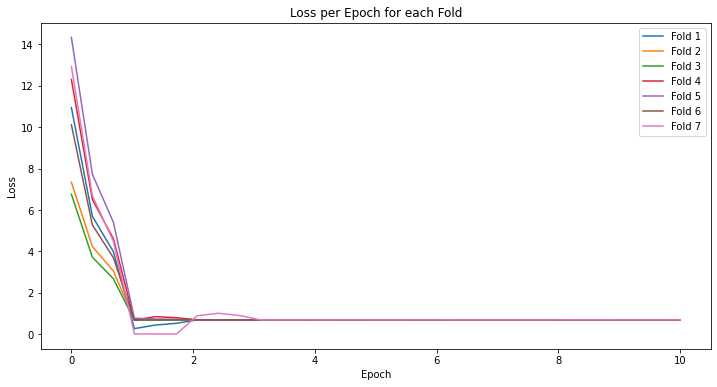

In [114]:
# Plot loss per epoch
plt.figure(figsize=(12, 6))
for fold_losses in losses_per_epoch:
    plt.plot(np.linspace(0, EPOCHS, EPOCHS*3), fold_losses, label=f'Fold {losses_per_epoch.index(fold_losses) + 1}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch for each Fold')
plt.legend()
plt.savefig(f'{figures_exp_path}/losses')
plt.show()

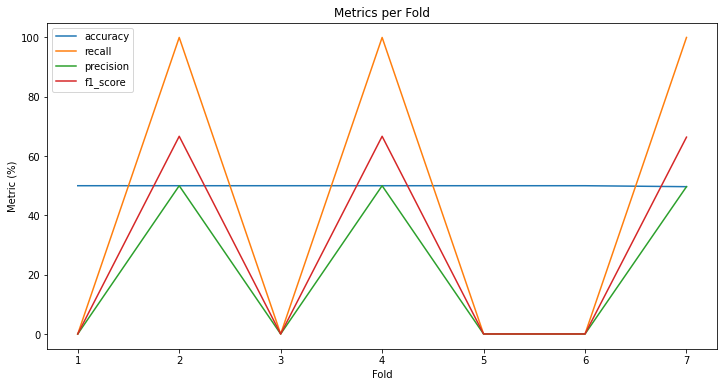

In [115]:
# Plot accuracy per fold
plt.figure(figsize=(12, 6))
for metric, values in results.items():
  plt.plot(range(1, groupk_folds + 1), values, label=f'{metric}')
plt.xlabel('Fold')
plt.ylabel('Metric (%)')
plt.title('Metrics per Fold')
plt.legend()
plt.savefig(f'{figures_exp_path}/metrics')
plt.show()

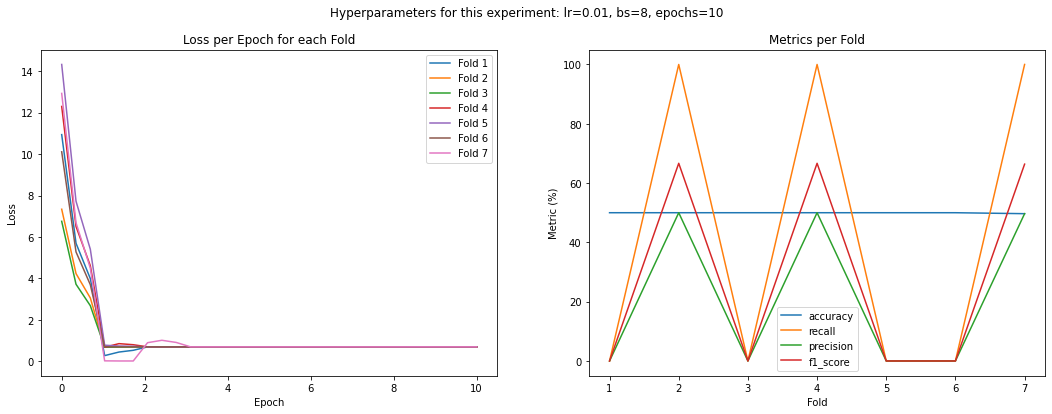

In [116]:
# Crear la figura y los subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Loss per epoch
for fold_losses in losses_per_epoch:
    ax1.plot(np.linspace(0, EPOCHS, EPOCHS * 3), fold_losses, label=f'Fold {losses_per_epoch.index(fold_losses) + 1}')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss per Epoch for each Fold')
ax1.legend()

# Plot 2: Metrics per fold
for metric, values in results.items():
    ax2.plot(range(1, groupk_folds + 1), values, label=f'{metric}')
ax2.set_xlabel('Fold')
ax2.set_ylabel('Metric (%)')
ax2.set_title('Metrics per Fold')
ax2.legend()

# Título principal
fig.suptitle(f'Hyperparameters for this experiment: lr={LEARNING_RATE}, bs={BATCH_SIZE}, epochs={EPOCHS}')

# Guardar y mostrar la figura
plt.savefig(f'{figures_exp_path}/combined_metrics')
plt.show()